## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
!pip install swifter

In [3]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics
from pprint import pprint
import swifter
import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Opening JSON file 
f = open('/content/drive/MyDrive/complaints-2021-05-14_08_16.json')

# returns JSON object as  
# a dictionary 
data = json.load(f)
complaint_tickets=pd.json_normalize(data)

## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.
complaint_tickets.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
#print the column names
complaint_tickets.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [8]:
#Check column values which are unnecessary or repeatitive
print(complaint_tickets['_index'].value_counts())
print(complaint_tickets['_type'].value_counts()) 
print(complaint_tickets['_id'].value_counts()) ## same as source.complaint_id
print(complaint_tickets['_score'].value_counts())

complaint-public-v2    78313
Name: _index, dtype: int64
complaint    78313
Name: _type, dtype: int64
360319     1
3123748    1
3658210    1
389223     1
3650518    1
          ..
1921446    1
339775     1
3604954    1
1306433    1
2905630    1
Name: _id, Length: 78313, dtype: int64
0.0    78313
Name: _score, dtype: int64


> #### Since _index, _type,_id, _score columns has repeatitive or single values, it has no significance and can be dropped

In [9]:
# Drop insignificant columns
complaint_tickets.drop(['_index', '_type', '_id', '_score'], axis=1, inplace=True)
complaint_tickets.head()

,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [10]:
#Assign new column names
complaint_tickets.columns = [str(col).replace('_source.','') for col in complaint_tickets.columns]
complaint_tickets.head()

,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [11]:
complaint_tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   tags                       10900 non-null  object
 1   zip_code                   71556 non-null  object
 2   complaint_id               78313 non-null  object
 3   issue                      78313 non-null  object
 4   date_received              78313 non-null  object
 5   state                      76322 non-null  object
 6   consumer_disputed          78313 non-null  object
 7   product                    78313 non-null  object
 8   company_response           78313 non-null  object
 9   company                    78313 non-null  object
 10  submitted_via              78313 non-null  object
 11  date_sent_to_company       78313 non-null  object
 12  company_public_response    4 non-null      object
 13  sub_product                67742 non-null  object
 14  timely

In [12]:
#Assign nan in place of blanks in the complaints column
complaint_tickets['complaint_what_happened'] = complaint_tickets['complaint_what_happened'].apply(lambda x: x if re.search('\s+',x) != None else pd.NA)
complaint_tickets.info()
complaint_tickets.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   tags                       10900 non-null  object
 1   zip_code                   71556 non-null  object
 2   complaint_id               78313 non-null  object
 3   issue                      78313 non-null  object
 4   date_received              78313 non-null  object
 5   state                      76322 non-null  object
 6   consumer_disputed          78313 non-null  object
 7   product                    78313 non-null  object
 8   company_response           78313 non-null  object
 9   company                    78313 non-null  object
 10  submitted_via              78313 non-null  object
 11  date_sent_to_company       78313 non-null  object
 12  company_public_response    4 non-null      object
 13  sub_product                67742 non-null  object
 14  timely

,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,<NA>,Debt is not yours,Consent not provided
1,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,<NA>,None,Consent not provided
4,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,<NA>,Charged too much interest,N/A


In [13]:
#Remove all rows where complaints column is nan
consumer_complaint_tickets = complaint_tickets[~complaint_tickets.complaint_what_happened.isna()]
consumer_complaint_tickets.info()
consumer_complaint_tickets.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21069 entries, 1 to 78312
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   tags                       3816 non-null   object
 1   zip_code                   16425 non-null  object
 2   complaint_id               21069 non-null  object
 3   issue                      21069 non-null  object
 4   date_received              21069 non-null  object
 5   state                      20926 non-null  object
 6   consumer_disputed          21069 non-null  object
 7   product                    21069 non-null  object
 8   company_response           21069 non-null  object
 9   company                    21069 non-null  object
 10  submitted_via              21069 non-null  object
 11  date_sent_to_company       21069 non-null  object
 12  company_public_response    2 non-null      object
 13  sub_product                18960 non-null  object
 14  timely

,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


In [14]:
## regex to be applied on compaints text to clean those
s='ADF'
s.lower()
print(re.sub('\s*\[+\w+\]+\s*','','[12345] ads'))
print(re.sub('[^\w\s]','' ,'edasd!, rtr; asds: dasd'))
print(re.sub('\s*\S*\d+\S*\s*','','$12345 retert'))

ads
edasd rtr asds dasd
retert


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def cleanText(inputText):
  cleanedText = ''
  if(inputText != ''):
    ## making the text lowercase
    cleanedText = inputText.lower()
    ## removing text in square brackets
    cleanedText = re.sub('\s*\[+\w+\]+\s*',' ',cleanedText)
    ## removing punctuation
    cleanedText = re.sub('[^\w\s]',' ',cleanedText)
    ## remove words containing numbers
    cleanedText = re.sub('\s*\S*\d+\S*\s*',' ',cleanedText)
  return cleanedText.strip()

In [16]:
#Write your function to Lemmatize the texts
def lemmatizedText(inputText):
  lemmatizedTexts = ''
  if(inputText != ''):
    tokens = nlp(inputText)
    for token in tokens:
      lemmatizedTexts = lemmatizedTexts+' '+token.lemma_
    lemmatizedTexts = lemmatizedTexts.strip()
    return lemmatizedTexts

In [17]:
## apply functions to test cleaned text and lemmatized text
consumer_complaint_tickets['cleaned_complaints_text'] = consumer_complaint_tickets['complaint_what_happened'].apply(lambda x: cleanText(x))
consumer_complaint_tickets['lemmatized_complaints_text'] = consumer_complaint_tickets['cleaned_complaints_text'].swifter.apply(lambda x: lemmatizedText(x))
consumer_complaint_tickets.head()

Pandas Apply:   0%|          | 0/21069 [00:00<?, ?it/s]

,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,cleaned_complaints_text,lemmatized_complaints_text
1,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...
2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in xx xx and was ...,i upgrade -PRON- xxxx xxxx card in xx xx and b...
10,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on xx xx however frau...,chase card be report on xx xx however fraudu...
11,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on xx xx while trying to book a xxxx xxxx ti...,on xx xx while try to book a xxxx xxxx tic...
14,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...


In [18]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = consumer_complaint_tickets[['complaint_what_happened','lemmatized_complaints_text']]

In [19]:
df_clean

,complaint_what_happened,lemmatized_complaints_text
1,Good morning my name is XXXX XXXX and I apprec...,good morning -PRON- name be xxxx xxxx and i ap...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade -PRON- xxxx xxxx card in xx xx and b...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on xx xx however fraudu...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while try to book a xxxx xxxx tic...
14,my grand son give me check for {$1600.00} i de...,-PRON- grand son give -PRON- check for i dep...
...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xx xx xxxx i call chas -PRON-...
78310,I am not familiar with XXXX pay and did not un...,i be not familiar with xxxx pay and do not und...
78311,I have had flawless credit for 30 yrs. I've ha...,i have have flawless credit for yrs i ve hav...


In [20]:
#Write your function to extract the POS tags 
def posTags(inputText):
  posTags =''
  if(inputText != ''):
    tokens = nlp(inputText)
    for token in tokens:
      if token.pos_ == 'NOUN':
        posTags += ' '+token.text
  
  return posTags.strip()

In [21]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.

df_clean['complaint_POS_removed'] = df_clean['lemmatized_complaints_text'].swifter.apply(lambda x: posTags(x))

Pandas Apply:   0%|          | 0/21069 [00:00<?, ?it/s]

In [ ]:
df_clean

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [23]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaint_length_dict =df_clean['complaint_POS_removed'].apply(lambda x:len(x)).value_counts()
complaint_length_df = pd.DataFrame().from_dict({'Character Length':list(complaint_length_dict.keys()), 'Frequency':complaint_length_dict.values})

fig = px.scatter(complaint_length_df, x="Character Length", y="Frequency",
           color="Character Length", log_x=True, hover_name="Character Length",
           size="Frequency")
fig.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

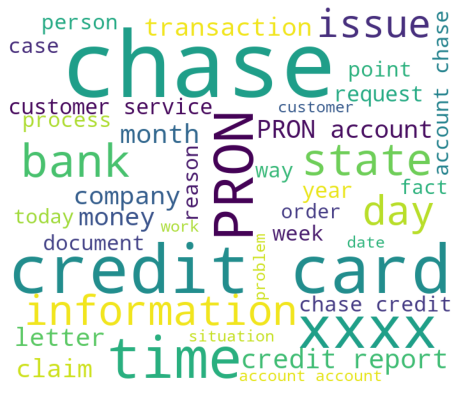

In [24]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
plt.subplots(figsize = (8,8))
wordcloud = WordCloud (
                    background_color = 'white',
                    width = 700,
                    height = 600, max_words=40
                        ).generate(' '.join(df_clean.complaint_POS_removed))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

In [25]:
#Removing -PRON-, xxxx from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].apply(lambda x: re.sub('\s*-PRON-+\s*|\s*xxxx+\s*',' ',x))
df_clean

,complaint_what_happened,lemmatized_complaints_text,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade -PRON- xxxx xxxx card in xx xx and b...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on xx xx however fraudu...,card report application submit identity consen...,card report application submit identity consen...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while try to book a xxxx xxxx tic...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...,son chase account fund account money say son c...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xx xx xxxx i call chas -PRON-...,card provider claim protection benefit school ...,card provider claim protection benefit school ...
78310,I am not familiar with XXXX pay and did not un...,i be not familiar with xxxx pay and do not und...,risk provide consumer chase year trust banking...,risk provide consumer chase year trust banking...
78311,I have had flawless credit for 30 yrs. I've ha...,i have have flawless credit for yrs i ve hav...,credit credit card chase freedom xxxx problem ...,credit credit card chase freedom problem balan...


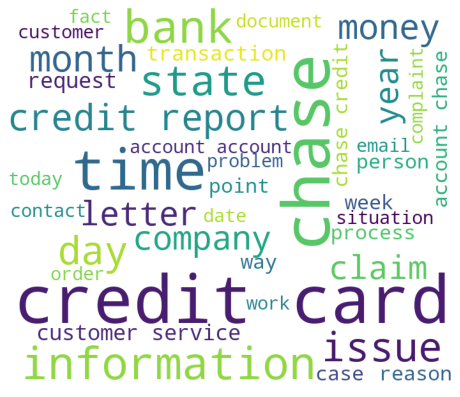

In [26]:
plt.subplots(figsize = (8,8))
wordcloud = WordCloud (
                    background_color = 'white',
                    width = 700,
                    height = 600, max_words=40
                        ).generate(' '.join(df_clean.Complaint_clean))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [27]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
wordFreq = {}
def getWordFreq(inputText):
  if(inputText != ''):
    for text in inputText.split(' '):
      if text in wordFreq:
        wordFreq[text] += 1
      else:
        wordFreq[text] = 1
df_clean.Complaint_clean.apply(lambda x:getWordFreq(x))

wordFreq_sorted = sorted(wordFreq.items(), key=lambda kv: kv[1], reverse=True)
print("Top 30 Unigram Frequency:")
print(*wordFreq_sorted[:30], sep="\n")

Top 30 Unigram Frequency:
('account', 46248)
('chase', 43187)
('credit', 33162)
('card', 30353)
('payment', 21099)
('bank', 16711)
('charge', 16404)
('time', 16262)
('day', 13039)
('money', 11989)
('check', 11930)
('loan', 10684)
('information', 9662)
('letter', 9567)
('call', 9273)
('report', 9265)
('fee', 8876)
('number', 8647)
('transaction', 8617)
('month', 8605)
('amount', 8440)
('year', 8435)
('customer', 8182)
('mortgage', 8118)
('state', 8117)
('claim', 8031)
('balance', 7714)
('phone', 7644)
('company', 7528)
('service', 7288)


In [28]:
#Print the top 10 words in the unigram frequency
print("Top 10 words in Unigram Frequency:")
for i in range(10):
  print(wordFreq_sorted[i][0])

Top 10 words in Unigram Frequency:
account
chase
credit
card
payment
bank
charge
time
day
money


In [29]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigramFreq={}
def getBigramFreq(inputText):
  if(inputText != ''):
    bigrams = ngrams(inputText.split(), 2)
    for item in bigrams:
      text = item[0]+"_"+item[1]
      if text in bigramFreq:
        bigramFreq[text] += 1
      else:
        bigramFreq[text] = 1
df_clean.Complaint_clean.apply(lambda x: getBigramFreq(x))
bigramFreq_sorted = sorted(bigramFreq.items(), key=lambda kv: kv[1], reverse=True)
print("Top 30 bigram frequency: ")
print(*bigramFreq_sorted[:30],sep="\n")

Top 30 bigram frequency: 
('credit_card', 12694)
('credit_report', 3927)
('customer_service', 2905)
('account_chase', 2544)
('chase_credit', 2518)
('account_account', 2329)
('bank_account', 2030)
('chase_account', 1955)
('debit_card', 1908)
('check_account', 1713)
('credit_score', 1712)
('card_account', 1699)
('phone_call', 1646)
('chase_card', 1523)
('payment_payment', 1409)
('money_account', 1395)
('account_credit', 1369)
('interest_rate', 1303)
('card_chase', 1292)
('phone_number', 1252)
('charge_account', 1239)
('business_day', 1197)
('account_number', 1184)
('card_card', 1125)
('card_company', 1112)
('mortgage_payment', 1040)
('card_credit', 1039)
('credit_account', 995)
('police_report', 986)
('chase_customer', 981)


In [30]:
#Print the top 10 words in the bigram frequency
print("Top 10 words in bigram frequency:")
for i in range(10):
  print(bigramFreq_sorted[i][0].replace("_"," "))

Top 10 words in bigram frequency:
credit card
credit report
customer service
account chase
chase credit
account account
bank account
chase account
debit card
check account


In [31]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).  
trigramFreq={}
def getTrigramFreq(inputText):
  if(inputText != '' and len(inputText.split())>3):
    trigrams = ngrams(inputText.split(), 3)
    for item in trigrams:
      text = item[0]+"_"+item[1]+"_"+item[2]
      if text in trigramFreq:
        trigramFreq[text] += 1
      else:
        trigramFreq[text] = 1
df_clean.Complaint_clean.apply(lambda x: getTrigramFreq(x))
trigramFreq_sorted = sorted(trigramFreq.items(), key=lambda kv: kv[1], reverse=True)
print("Top 30 trigram frequency: ")
print(*trigramFreq_sorted[:30],sep="\n")

Top 30 trigram frequency: 
('chase_credit_card', 1767)
('credit_card_account', 1081)
('credit_card_company', 967)
('credit_card_chase', 580)
('charge_credit_card', 519)
('inquiry_credit_report', 507)
('credit_card_credit', 505)
('chase_customer_service', 429)
('account_credit_card', 427)
('card_credit_card', 408)
('credit_reporting_agency', 367)
('credit_card_charge', 343)
('customer_service_representative', 336)
('credit_report_credit', 320)
('credit_card_payment', 306)
('credit_card_card', 272)
('credit_reporting_act', 261)
('account_credit_report', 259)
('victim_identity_theft', 255)
('credit_card_balance', 254)
('payment_credit_card', 241)
('chase_check_account', 237)
('credit_card_statement', 218)
('freedom_credit_card', 208)
('account_chase_account', 208)
('credit_report_chase', 196)
('credit_card_year', 195)
('credit_card_service', 194)
('report_credit_report', 192)
('credit_card_number', 189)


In [32]:
#Print the top 10 words in the trigram frequency
print("Top 10 words in trigram frequency:")
for i in range(10):
  print(trigramFreq_sorted[i][0].replace("_"," "))

Top 10 words in trigram frequency:
chase credit card
credit card account
credit card company
credit card chase
charge credit card
inquiry credit report
credit card credit
chase customer service
account credit card
card credit card


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [33]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [34]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaints_text,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade -PRON- xxxx xxxx card in xx xx and b...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on xx xx however fraudu...,card report application submit identity consen...,card report application submit identity consen...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while try to book a xxxx xxxx tic...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...,son chase account fund account money say son c...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xx xx xxxx i call chas -PRON-...,card provider claim protection benefit school ...,card provider claim protection benefit school ...
78310,I am not familiar with XXXX pay and did not un...,i be not familiar with xxxx pay and do not und...,risk provide consumer chase year trust banking...,risk provide consumer chase year trust banking...
78311,I have had flawless credit for 30 yrs. I've ha...,i have have flawless credit for yrs i ve hav...,credit credit card chase freedom xxxx problem ...,credit credit card chase freedom problem balan...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [35]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [36]:
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])
pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names())

,aaa,aarp,ab,abandon,abandonment,abatement,abbreviation,abet,abide,abiding,ability,about,abscond,absence,absolve,absorb,absurdity,abundance,abuse,abuser,ac,acccount,acceleration,accent,accept,acceptance,access,accessibility,accessory,accident,acco,accommodation,accomodation,accompany,accomplice,accomplish,accont,accord,accordance,accou,...,worth,worthiness,worthlessness,woudl,would,wound,wrangle,wrap,wreck,wrist,wristband,writ,write,writer,writing,writte,wrong,wrongdoe,wrongdoing,www,xx,yard,yea,year,yell,yelp,yesterday,yield,yo,yoga,you,your,youth,yr,yrs,ys,ytd,zip,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [37]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [38]:
#Load your nmf_model with the n_components i.e 5
num_topics = 10

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [39]:
model= nmf_model.fit_transform(dtm)
H = nmf_model.components_
len(tfidf.get_feature_names())

6343

In [40]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,chase,reason,bank,deposit,saving,checking,branch,business,fund,access,money,year,balance,name
Topic 2,card,credit,chase,score,limit,point,year,offer,application,use,time,purchase,company,reason,service
Topic 3,payment,month,day,auto,time,statement,chase,credit,amount,bill,pay,mortgage,date,car,report
Topic 4,charge,dispute,merchant,amount,company,fraud,chase,purchase,statement,refund,service,item,bill,date,billing
Topic 5,loan,mortgage,modification,home,chase,property,year,document,foreclosure,sale,letter,house,time,rate,request
Topic 6,report,inquiry,credit,company,information,reporting,debt,score,identity,bureaus,file,date,theft,bureau,creditor
Topic 7,check,deposit,fund,bank,cash,money,day,branch,hold,amount,cashier,business,chase,teller,mail
Topic 8,fee,overdraft,transaction,charge,fund,year,bank,time,dollar,customer,day,bill,service,refund,month
Topic 9,money,transaction,claim,bank,chase,number,call,phone,fraud,day,email,information,time,transfer,customer
Topic 10,balance,interest,rate,statement,transfer,amount,pay,purchase,month,date,offer,advance,period,credit,increase


In [41]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

# 'Topic 1 : 0 (Bank account services)'

# 'Topic 2 : 1 (Credit card / Prepaid card)'
# 'Topic 3 : 1 (Credit card / Prepaid card)'
# 'Topic 4 : 4 (Theft/Dispute reporting)'
# 'Topic 5 : 2 (Mortgages/loans)'
# 'Topic 6 : 4 (Theft/Dispute reporting)'
# 'Topic 7 : 0 (Bank account services)'
# 'Topic 8 : 3 (Bank account services)'
# 'Topic 9 : 4 (Theft/Dispute reporting)'
# 'Topic 10 : 0 (Bank account services)


topic_mapping = {
    'Topic 1': 0,
    'Topic 2': 1,
    'Topic 3': 2,
    'Topic 4': 4,
    'Topic 5': 2,
    'Topic 6': 4,
    'Topic 7': 0,
    'Topic 8': 3,
    'Topic 9': 4,
    'Topic 10': 0
}

W = pd.DataFrame(model, columns=[f'Topic {i + 1}' for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,max_topic
0,0.002386,0.000000,0.005089,0.000000,0.010104,0.010448,0.007224,0.003493,0.024698,0.013969,4
1,0.010207,0.015544,0.001189,0.001409,0.003532,0.000507,0.000000,0.000693,0.007806,0.001846,1
2,0.001994,0.030202,0.000000,0.000000,0.000000,0.032815,0.000000,0.000311,0.000000,0.000000,4
3,0.019920,0.033153,0.000021,0.000000,0.011618,0.034879,0.000000,0.000063,0.009467,0.003080,4
4,0.020895,0.000000,0.000000,0.000000,0.000000,0.000000,0.078245,0.000000,0.036092,0.000000,0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.091164,0.000000,0.000000,0.000000,0.000000,4
6,0.037368,0.008633,0.012365,0.000000,0.006141,0.000000,0.033985,0.014829,0.028061,0.000000,0
7,0.004077,0.006831,0.056479,0.000311,0.039250,0.000000,0.000000,0.000000,0.016825,0.000000,2
8,0.000000,0.000000,0.003587,0.000000,0.000800,0.011234,0.000000,0.005063,0.106800,0.000559,4
9,0.000000,0.091296,0.004037,0.002801,0.003128,0.065752,0.003040,0.000000,0.002698,0.000000,1


In [42]:
# Reset Indexes and drop existing indexes to assign topics derived using NMF
df_clean = df_clean.reset_index()
df_clean = df_clean.drop(['index'], axis=1)
df_clean

,complaint_what_happened,lemmatized_complaints_text,complaint_POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade -PRON- xxxx xxxx card in xx xx and b...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card be report on xx xx however fraudu...,card report application submit identity consen...,card report application submit identity consen...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while try to book a xxxx xxxx tic...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
4,my grand son give me check for {$1600.00} i de...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...,son chase account fund account money say son c...
...,...,...,...,...
21064,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
21065,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xx xx xxxx i call chas -PRON-...,card provider claim protection benefit school ...,card provider claim protection benefit school ...
21066,I am not familiar with XXXX pay and did not un...,i be not familiar with xxxx pay and do not und...,risk provide consumer chase year trust banking...,risk provide consumer chase year trust banking...
21067,I have had flawless credit for 30 yrs. I've ha...,i have have flawless credit for yrs i ve hav...,credit credit card chase freedom xxxx problem ...,credit credit card chase freedom problem balan...


In [43]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W['max_topic'] #write your code to assign topics to each rows.
df_clean

,complaint_what_happened,lemmatized_complaints_text,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,4
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade -PRON- xxxx xxxx card in xx xx and b...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card be report on xx xx however fraudu...,card report application submit identity consen...,card report application submit identity consen...,4
3,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while try to book a xxxx xxxx tic...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,4
4,my grand son give me check for {$1600.00} i de...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...,son chase account fund account money say son c...,0
...,...,...,...,...,...
21064,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
21065,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xx xx xxxx i call chas -PRON-...,card provider claim protection benefit school ...,card provider claim protection benefit school ...,4
21066,I am not familiar with XXXX pay and did not un...,i be not familiar with xxxx pay and do not und...,risk provide consumer chase year trust banking...,risk provide consumer chase year trust banking...,4
21067,I have had flawless credit for 30 yrs. I've ha...,i have have flawless credit for yrs i ve hav...,credit credit card chase freedom xxxx problem ...,credit credit card chase freedom problem balan...,2


In [44]:
#Print the first 5 Complaint for each of the Topics
df_clean_first_5=df_clean.groupby('Topic').head(5)
df_clean_first_5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaints_text,complaint_POS_removed,Complaint_clean,Topic
15,I opened the saving account for the {$25.00} b...,i open the saving account for the bonus i ...,saving account bonus bonus auto transfer check...,saving account bonus bonus auto transfer check...,0
4,my grand son give me check for {$1600.00} i de...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...,son chase account fund account money say son c...,0
6,With out notice J.P. Morgan Chase restricted m...,with out notice j p morgan chase restrict -P...,notice chase restrict account card branch cust...,notice chase restrict account card branch cust...,0
10,mishandling of this account by Chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account,mishandle account,0
12,I opened an account with chase bank on XXXX an...,i open an account with chase bank on xxxx and ...,account code bonus term account xxxx deposit b...,account code bonus term account deposit bonus ...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade -PRON- xxxx xxxx card in xx xx and b...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
21,I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...,i be a senior citizen that have be scamme by s...,citizen scamme company pay time company refund...,citizen scamme company pay time company refund...,1
14,My chase amazon card was declined for a cateri...,-PRON- chase amazon card be decline for a cate...,card decline catering order place brother fune...,card decline catering order place brother fune...,1
22,My roommate was stealing my Chase debit card a...,-PRON- roommate be steal -PRON- chase debit ca...,roommate steal debit card driver license money...,roommate steal debit card driver license money...,1
9,I have a Chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,chase credit card credit report company help i...,chase credit card credit report company help i...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [45]:
#Create the dictionary of Topic names and Topics

Topic_names = {
     0 : 'Bank account services',
     1 : 'Credit card / Prepaid card',
     2 : 'Mortgages/loans',
     3 : 'Others',
     4 : 'Theft/Dispute reporting'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [46]:
with pd.option_context('display.max_colwidth', None):
  display(df_clean)

,complaint_what_happened,lemmatized_complaints_text,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer advance help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer advance help,Theft/Dispute reporting
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgrade -PRON- xxxx xxxx card in xx xx and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xx xx xxxx to xx xx xxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,card agent anniversary date agent information order account change anniversary date consent xxxx recording agent,card agent anniversary date agent information order account change anniversary date consent recording agent,Credit card / Prepaid card
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card be report on xx xx however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application submit identity consent service credit identity applicant,card report application submit identity consent service credit identity applicant,Theft/Dispute reporting
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins afte

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [47]:
#Create the dictionary again of Topic names and Topics

Topic_names = { 
     'Bank account services' : 0,
     'Credit card / Prepaid card' : 1,
     'Mortgages/loans' : 2,
     'Others' : 3,
     'Theft/Dispute reporting' : 4 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [48]:
df_clean

,complaint_what_happened,lemmatized_complaints_text,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,4
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade -PRON- xxxx xxxx card in xx xx and b...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card be report on xx xx however fraudu...,card report application submit identity consen...,card report application submit identity consen...,4
3,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while try to book a xxxx xxxx tic...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,4
4,my grand son give me check for {$1600.00} i de...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...,son chase account fund account money say son c...,0
...,...,...,...,...,...
21064,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
21065,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xx xx xxxx i call chas -PRON-...,card provider claim protection benefit school ...,card provider claim protection benefit school ...,4
21066,I am not familiar with XXXX pay and did not un...,i be not familiar with xxxx pay and do not und...,risk provide consumer chase year trust banking...,risk provide consumer chase year trust banking...,4
21067,I have had flawless credit for 30 yrs. I've ha...,i have have flawless credit for yrs i ve hav...,credit credit card chase freedom xxxx problem ...,credit credit card chase freedom problem balan...,2


In [49]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [50]:
#Write your code to get the Vector count
vectorizer = CountVectorizer(max_df=0.95, min_df=2)
X = vectorizer.fit_transform(training_data['complaint_what_happened'])

tfidf_transformer = TfidfTransformer()
tfidf_vector = tfidf_transformer.fit_transform(X)
X = tfidf_vector.toarray()
y = training_data['Topic']
tfidf_vector_df = pd.DataFrame(tfidf_vector.toarray(), columns=vectorizer.get_feature_names())
tfidf_vector_df

,00,000,000s,001,01,0111,02,03,04,05,06,07,08,08217,09,0f,0n,10,100,1000,10000,100000,1000s,1002,1005,100k,100pts,100s,100th,101,1017,102,1024,1026,1028,1029,103,1036,104,1040,...,yield,yielded,yielding,yields,yikes,yment,yo,yoga,york,you,youd,youinvest,youll,young,younger,youngest,your,youre,yours,yourself,yourselves,youth,youve,youxxxx,yr,yrs,ys,ytd,yup,zelle,zero,zeroed,zeros,zilch,zip,zipcode,zombie,zone,zones,zoom
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082112,0.0,0.0,0.0,0.0,0.0,0.0,0.101091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.026359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.043965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21064,0.039363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.093205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21065,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21066,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.058348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21067,0.118023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
 print(X_train.shape)
 print(X_test.shape)
 print(y_train.shape)
 print(y_test.shape)

(14748, 16253)
(6321, 16253)
(14748,)
(6321,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [66]:
# Write your code here to build any 3 models and evaluate them using the required metrics

#LogisticRegression Model
log_reg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
log_reg_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [67]:
y_pred_log_reg = log_reg_model.predict(X_test)
print("Logistic Regression")
print("Accuracy: ",metrics.accuracy_score(y_test,y_pred_log_reg))
print("F1 Score: ",metrics.f1_score(y_test,y_pred_log_reg, average=None))


Logistic Regression
Accuracy:  0.8791330485682645
F1 Score:  [0.86342944 0.87262079 0.91536458 0.81936685 0.87350506]


In [57]:
#DecisionTreeClassifier Model
dec_tree_model = DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=42)
dec_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [59]:
y_pred_dec_tree = dec_tree_model.predict(X_test)
print("DecisionTree Classifier")
print("Accuracy: ", metrics.accuracy_score(y_test,y_pred_dec_tree))
print("F1 Score: ",metrics.f1_score(y_test,y_pred_dec_tree, average=None))

DecisionTree Classifier
Accuracy:  0.6641354216105047
F1 Score:  [0.65016234 0.63083605 0.77463348 0.25954198 0.6502994 ]


In [60]:
#RandomForestClassifier Model
random_forest_model = RandomForestClassifier(n_estimators=5, max_depth = 5, random_state=42)
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [61]:
y_pred_random_forest = random_forest_model.predict(X_test)
print("RandomForest Classifier")
print("Accuracy: ", metrics.accuracy_score(y_test,y_pred_random_forest))
print("F1 Score: ",metrics.f1_score(y_test,y_pred_random_forest, average=None))

RandomForest Classifier
Accuracy:  0.4608448030374941
F1 Score:  [0.32324386 0.24763407 0.48214286 0.         0.54619949]


In [62]:
from sklearn.naive_bayes import MultinomialNB

#NaiveBayes Classifier Model
naive_bayes_model = MultinomialNB(alpha=0.01)
naive_bayes_model.fit(X_train, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [64]:
y_pred_multi_nb= naive_bayes_model.predict(X_test)
print("NaiveBayes Classifier")
print("Accuracy: ", metrics.accuracy_score(y_test,y_pred_multi_nb))
print("F1 Score: ",metrics.f1_score(y_test,y_pred_multi_nb, average=None))


NaiveBayes Classifier
Accuracy:  0.7117544692295523
F1 Score:  [0.67126966 0.60243632 0.80883281 0.5        0.73129473]
